# LSTM, GRU and RNN Time Series Explorations with Keras

This is a very short exploration into applying RNN (LSTM, GRU) techniques using the Keras library. Code and content is based on several cool blog posts and papers; see references section for more info.

In [1]:
# Let's load the required libs.
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, LeakyReLU
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers.convolutional import Conv1D, MaxPooling1D
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

Using TensorFlow backend.


# Example 1: Sinus wave data

For the firstexample, we'll generate synthetic data from a sinus curve, i.e.:  y=sin(x) .

We'll build a multiple regression model where we treat a range of input values at previous time steps as inputs for predicting the output value at the next time step.

The number of previous time steps is called the window size. In the below we'll be using a window size of  50 , i.e.:

Xt=f(Xt−1,Xt−2,...,Xt−50,Θ)
 
## Generating and plotting the data

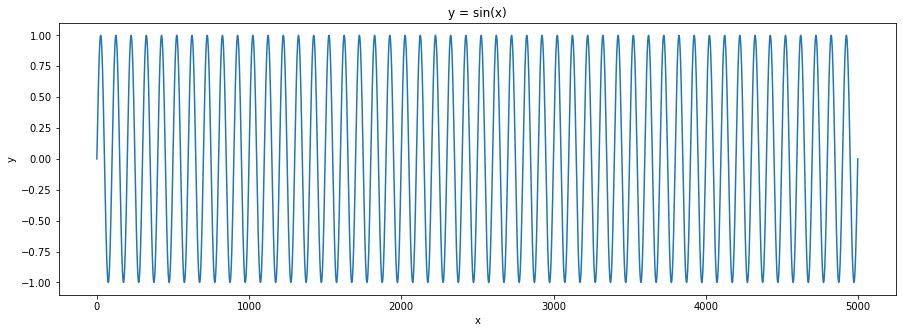

In [2]:
SAMPLES = 5000
PERIOD = 50
x = np.linspace(-PERIOD * np.pi, PERIOD * np.pi, SAMPLES)
series = pd.DataFrame(np.sin(x))

plt.figure(figsize = (15, 5))
plt.plot(series.values)
plt.xlabel("x")
plt.ylabel("y")
plt.title("y = sin(x)")
plt.show()

## Data Preparation

First, we'll demonstrate the sliding window principle using a window size of 1; subsequently we'll move on to window size 50.

In [3]:
# Normalize data on the (-1, 1) interval.
scaler = MinMaxScaler(feature_range = (-1, 1))
scaled = scaler.fit_transform(series.values)

# Convert to data frame.
series = pd.DataFrame(scaled)

# Helper function to create a windowed data set.

def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], 
                            axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

series_backup = series.copy()
t = create_window(series_backup, 1)
t.head()

,0,0
0,-9.821934e-16,0.062803
1,6.280307e-02,0.125358
2,1.253582e-01,0.187418
3,1.874184e-01,0.248739
4,2.487386e-01,0.309077


In [4]:
window_size = 50
series = create_window(series, window_size)
print("Shape of input data:")
print(series.shape)

Shape of input data:
(4950, 51)


Split into train/test set

In [5]:
# Using 80% of data for training, 20% for validation.

TRAIN_SIZE = 0.80

nrow = round(TRAIN_SIZE * series.shape[0])

train = series.iloc[:nrow, :]
test = series.iloc[nrow:, :]

# Shuffle training data.
train = shuffle(train)

train_X = train.iloc[:, :-1]
test_X = test.iloc[:, :-1]

train_Y = train.iloc[:, -1]
test_Y = test.iloc[:, -1]

print("Training set shape for X (inputs):")
print(train_X.shape)
print("Training set shape for Y (output):")
print(train_Y.shape)

Training set shape for X (inputs):
(3960, 50)
Training set shape for Y (output):
(3960,)


Get data into shape to use in Keras

In [6]:
train_X = np.reshape(train_X.values, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X.values, (test_X.shape[0], test_X.shape[1], 1))

print(train_X.shape)
print(test_X.shape)

(3960, 50, 1)
(990, 50, 1)


## Build RNN model on training data

In [7]:
window_size = 50

# Define the model.
model = Sequential()
model.add(SimpleRNN(4, input_shape = (window_size, 1)))
model.add(Dense(1))

model.compile(loss = "mean_squared_error", optimizer = "adam")

model.summary()

# Fit the first model.
history = model.fit(train_X, train_Y, epochs = 500, batch_size = train_X.shape[0], validation_data = (test_X, test_Y))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
Train on 3960 samples, validate on 990 samples
Epoch 1/500
3960/3960 [==============================] - 1s 152us/step - loss: 0.4288 - val_loss: 0.4246
Epoch 2/500
3960/3960 [==============================] - 0s 15us/step - loss: 0.4234 - val_loss: 0.4192
Epoch 3/500
3960/3960 [==============================] - 0s 16us/step - loss: 0.4181 - val_loss: 0.4139
Epoch 4/500
3960/3960 [==============================] - 0s 15us/step - loss: 0.4129 - val_loss: 0.4087
Epoch 5/500
3960/3960 [==============================] -

Epoch 73/500
3960/3960 [==============================] - 0s 15us/step - loss: 0.1792 - val_loss: 0.1773
Epoch 74/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.1772 - val_loss: 0.1754
Epoch 75/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.1753 - val_loss: 0.1735
Epoch 76/500
3960/3960 [==============================] - 0s 15us/step - loss: 0.1734 - val_loss: 0.1716
Epoch 77/500
3960/3960 [==============================] - 0s 13us/step - loss: 0.1716 - val_loss: 0.1698
Epoch 78/500
3960/3960 [==============================] - 0s 13us/step - loss: 0.1697 - val_loss: 0.1680
Epoch 79/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.1679 - val_loss: 0.1662
Epoch 80/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.1662 - val_loss: 0.1645
Epoch 81/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.1644 - val_loss: 0.1627
Epoch 82/500
3960/3960 [==============================]

Epoch 151/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0867 - val_loss: 0.0863
Epoch 152/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0861 - val_loss: 0.0856
Epoch 153/500
3960/3960 [==============================] - 0s 12us/step - loss: 0.0854 - val_loss: 0.0849
Epoch 154/500
3960/3960 [==============================] - 0s 13us/step - loss: 0.0848 - val_loss: 0.0843
Epoch 155/500
3960/3960 [==============================] - 0s 13us/step - loss: 0.0841 - val_loss: 0.0837
Epoch 156/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0835 - val_loss: 0.0830
Epoch 157/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0828 - val_loss: 0.0824
Epoch 158/500
3960/3960 [==============================] - 0s 13us/step - loss: 0.0822 - val_loss: 0.0818
Epoch 159/500
3960/3960 [==============================] - 0s 17us/step - loss: 0.0816 - val_loss: 0.0812
Epoch 160/500
3960/3960 [=====================

Epoch 229/500
3960/3960 [==============================] - 0s 15us/step - loss: 0.0516 - val_loss: 0.0516
Epoch 230/500
3960/3960 [==============================] - 0s 15us/step - loss: 0.0513 - val_loss: 0.0513
Epoch 231/500
3960/3960 [==============================] - 0s 16us/step - loss: 0.0510 - val_loss: 0.0510
Epoch 232/500
3960/3960 [==============================] - 0s 16us/step - loss: 0.0508 - val_loss: 0.0507
Epoch 233/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0505 - val_loss: 0.0504
Epoch 234/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0502 - val_loss: 0.0501
Epoch 235/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0499 - val_loss: 0.0499
Epoch 236/500
3960/3960 [==============================] - 0s 15us/step - loss: 0.0496 - val_loss: 0.0496
Epoch 237/500
3960/3960 [==============================] - 0s 15us/step - loss: 0.0494 - val_loss: 0.0493
Epoch 238/500
3960/3960 [=====================

Epoch 307/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0351 - val_loss: 0.0351
Epoch 308/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0349 - val_loss: 0.0350
Epoch 309/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0348 - val_loss: 0.0348
Epoch 310/500
3960/3960 [==============================] - 0s 13us/step - loss: 0.0346 - val_loss: 0.0347
Epoch 311/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0345 - val_loss: 0.0345
Epoch 312/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0343 - val_loss: 0.0344
Epoch 313/500
3960/3960 [==============================] - 0s 13us/step - loss: 0.0342 - val_loss: 0.0342
Epoch 314/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0340 - val_loss: 0.0341
Epoch 315/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0339 - val_loss: 0.0339
Epoch 316/500
3960/3960 [=====================

Epoch 385/500
3960/3960 [==============================] - 0s 13us/step - loss: 0.0259 - val_loss: 0.0260
Epoch 386/500
3960/3960 [==============================] - 0s 13us/step - loss: 0.0258 - val_loss: 0.0259
Epoch 387/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0257 - val_loss: 0.0258
Epoch 388/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0256 - val_loss: 0.0257
Epoch 389/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0256 - val_loss: 0.0256
Epoch 390/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0255 - val_loss: 0.0256
Epoch 391/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0254 - val_loss: 0.0255
Epoch 392/500
3960/3960 [==============================] - 0s 13us/step - loss: 0.0253 - val_loss: 0.0254
Epoch 393/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0252 - val_loss: 0.0253
Epoch 394/500
3960/3960 [=====================

Epoch 463/500
3960/3960 [==============================] - 0s 14us/step - loss: 0.0203 - val_loss: 0.0204
Epoch 464/500
3960/3960 [==============================] - 0s 13us/step - loss: 0.0202 - val_loss: 0.0203
Epoch 465/500
3960/3960 [==============================] - 0s 13us/step - loss: 0.0202 - val_loss: 0.0203
Epoch 466/500
3960/3960 [==============================] - 0s 13us/step - loss: 0.0201 - val_loss: 0.0202
Epoch 467/500
3960/3960 [==============================] - 0s 13us/step - loss: 0.0201 - val_loss: 0.0202
Epoch 468/500
3960/3960 [==============================] - 0s 12us/step - loss: 0.0200 - val_loss: 0.0201
Epoch 469/500
3960/3960 [==============================] - 0s 13us/step - loss: 0.0199 - val_loss: 0.0200
Epoch 470/500
3960/3960 [==============================] - 0s 13us/step - loss: 0.0199 - val_loss: 0.0200
Epoch 471/500
3960/3960 [==============================] - 0s 13us/step - loss: 0.0198 - val_loss: 0.0199
Epoch 472/500
3960/3960 [=====================

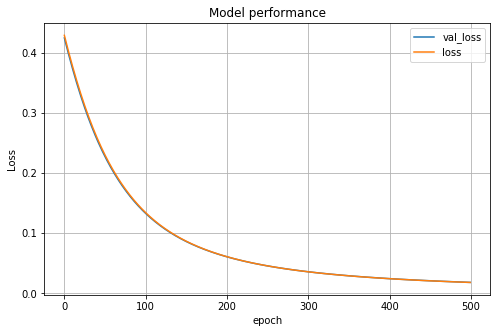

In [8]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [9]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = np.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 0.14 RMSE
Test data score: 0.14 RMSE


MSE for predicted test set: 0.018428


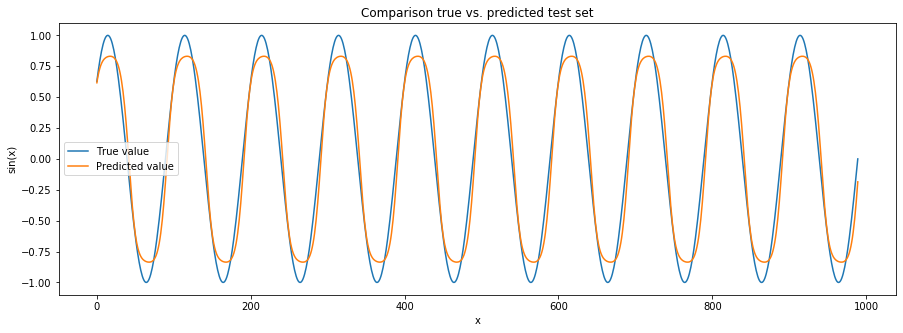

In [10]:
# Predict on test data.
pred_test = model.predict(test_X)

# Apply inverse transformation to get back true values.
test_y_actual = scaler.inverse_transform(test_Y.values.reshape(test_Y.shape[0], 1))

print("MSE for predicted test set: %2f" % mean_squared_error(test_y_actual, pred_test))

plt.figure(figsize = (15, 5))
plt.plot(test_y_actual, label="True value")
plt.plot(pred_test, label="Predicted value")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.title("Comparison true vs. predicted test set")
plt.legend()
plt.show()

## Build GRU model on training data

In [11]:
window_size = 50

# Define the model.
model = Sequential()
model.add(GRU(4, input_shape = (window_size, 1)))
model.add(Dense(1))

model.compile(loss = "mean_squared_error", optimizer = "adam")

model.summary()

# Fit the model.
history = model.fit(train_X, train_Y, epochs = 500, batch_size = train_X.shape[0], validation_data = (test_X, test_Y))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 4)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________
Train on 3960 samples, validate on 990 samples
Epoch 1/500
3960/3960 [==============================] - 2s 407us/step - loss: 0.9485 - val_loss: 0.9528
Epoch 2/500
3960/3960 [==============================] - 0s 58us/step - loss: 0.9432 - val_loss: 0.9467
Epoch 3/500
3960/3960 [==============================] - 0s 68us/step - loss: 0.9372 - val_loss: 0.9402
Epoch 4/500
3960/3960 [==============================] - 0s 55us/step - loss: 0.9309 - val_loss: 0.9336
Epoch 5/500
3960/3960 [==============================] -

Epoch 73/500
3960/3960 [==============================] - 0s 40us/step - loss: 0.5337 - val_loss: 0.5341
Epoch 74/500
3960/3960 [==============================] - 0s 41us/step - loss: 0.5291 - val_loss: 0.5295
Epoch 75/500
3960/3960 [==============================] - 0s 40us/step - loss: 0.5245 - val_loss: 0.5249
Epoch 76/500
3960/3960 [==============================] - 0s 40us/step - loss: 0.5200 - val_loss: 0.5204
Epoch 77/500
3960/3960 [==============================] - 0s 40us/step - loss: 0.5155 - val_loss: 0.5159
Epoch 78/500
3960/3960 [==============================] - 0s 40us/step - loss: 0.5110 - val_loss: 0.5114
Epoch 79/500
3960/3960 [==============================] - 0s 40us/step - loss: 0.5066 - val_loss: 0.5069
Epoch 80/500
3960/3960 [==============================] - 0s 41us/step - loss: 0.5022 - val_loss: 0.5025
Epoch 81/500
3960/3960 [==============================] - 0s 44us/step - loss: 0.4978 - val_loss: 0.4981
Epoch 82/500
3960/3960 [==============================]

Epoch 151/500
3960/3960 [==============================] - 0s 49us/step - loss: 0.2516 - val_loss: 0.2510
Epoch 152/500
3960/3960 [==============================] - 0s 48us/step - loss: 0.2489 - val_loss: 0.2483
Epoch 153/500
3960/3960 [==============================] - 0s 41us/step - loss: 0.2461 - val_loss: 0.2456
Epoch 154/500
3960/3960 [==============================] - 0s 42us/step - loss: 0.2434 - val_loss: 0.2428
Epoch 155/500
3960/3960 [==============================] - 0s 42us/step - loss: 0.2407 - val_loss: 0.2401
Epoch 156/500
3960/3960 [==============================] - 0s 47us/step - loss: 0.2381 - val_loss: 0.2375
Epoch 157/500
3960/3960 [==============================] - 0s 48us/step - loss: 0.2354 - val_loss: 0.2348
Epoch 158/500
3960/3960 [==============================] - 0s 43us/step - loss: 0.2328 - val_loss: 0.2322
Epoch 159/500
3960/3960 [==============================] - 0s 43us/step - loss: 0.2302 - val_loss: 0.2296
Epoch 160/500
3960/3960 [=====================

Epoch 229/500
3960/3960 [==============================] - 0s 45us/step - loss: 0.0925 - val_loss: 0.0919
Epoch 230/500
3960/3960 [==============================] - 0s 43us/step - loss: 0.0912 - val_loss: 0.0905
Epoch 231/500
3960/3960 [==============================] - 0s 44us/step - loss: 0.0898 - val_loss: 0.0892
Epoch 232/500
3960/3960 [==============================] - 0s 50us/step - loss: 0.0885 - val_loss: 0.0879
Epoch 233/500
3960/3960 [==============================] - 0s 47us/step - loss: 0.0872 - val_loss: 0.0865
Epoch 234/500
3960/3960 [==============================] - 0s 43us/step - loss: 0.0859 - val_loss: 0.0852
Epoch 235/500
3960/3960 [==============================] - 0s 43us/step - loss: 0.0846 - val_loss: 0.0840
Epoch 236/500
3960/3960 [==============================] - 0s 41us/step - loss: 0.0833 - val_loss: 0.0827
Epoch 237/500
3960/3960 [==============================] - 0s 43us/step - loss: 0.0820 - val_loss: 0.0814
Epoch 238/500
3960/3960 [=====================

Epoch 307/500
3960/3960 [==============================] - 0s 51us/step - loss: 0.0267 - val_loss: 0.0264
Epoch 308/500
3960/3960 [==============================] - 0s 56us/step - loss: 0.0263 - val_loss: 0.0260
Epoch 309/500
3960/3960 [==============================] - 0s 55us/step - loss: 0.0259 - val_loss: 0.0256
Epoch 310/500
3960/3960 [==============================] - 0s 52us/step - loss: 0.0255 - val_loss: 0.0252
Epoch 311/500
3960/3960 [==============================] - 0s 57us/step - loss: 0.0251 - val_loss: 0.0249
Epoch 312/500
3960/3960 [==============================] - 0s 52us/step - loss: 0.0247 - val_loss: 0.0245
Epoch 313/500
3960/3960 [==============================] - 0s 46us/step - loss: 0.0243 - val_loss: 0.0241
Epoch 314/500
3960/3960 [==============================] - 0s 44us/step - loss: 0.0240 - val_loss: 0.0238
Epoch 315/500
3960/3960 [==============================] - 0s 41us/step - loss: 0.0236 - val_loss: 0.0234
Epoch 316/500
3960/3960 [=====================

Epoch 385/500
3960/3960 [==============================] - 0s 41us/step - loss: 0.0113 - val_loss: 0.0113
Epoch 386/500
3960/3960 [==============================] - 0s 42us/step - loss: 0.0113 - val_loss: 0.0113
Epoch 387/500
3960/3960 [==============================] - 0s 41us/step - loss: 0.0112 - val_loss: 0.0112
Epoch 388/500
3960/3960 [==============================] - 0s 41us/step - loss: 0.0111 - val_loss: 0.0112
Epoch 389/500
3960/3960 [==============================] - 0s 41us/step - loss: 0.0111 - val_loss: 0.0111
Epoch 390/500
3960/3960 [==============================] - 0s 43us/step - loss: 0.0110 - val_loss: 0.0110
Epoch 391/500
3960/3960 [==============================] - 0s 41us/step - loss: 0.0110 - val_loss: 0.0110
Epoch 392/500
3960/3960 [==============================] - 0s 42us/step - loss: 0.0109 - val_loss: 0.0109
Epoch 393/500
3960/3960 [==============================] - 0s 41us/step - loss: 0.0109 - val_loss: 0.0109
Epoch 394/500
3960/3960 [=====================

Epoch 463/500
3960/3960 [==============================] - 0s 41us/step - loss: 0.0088 - val_loss: 0.0089
Epoch 464/500
3960/3960 [==============================] - 0s 41us/step - loss: 0.0088 - val_loss: 0.0089
Epoch 465/500
3960/3960 [==============================] - 0s 44us/step - loss: 0.0088 - val_loss: 0.0089
Epoch 466/500
3960/3960 [==============================] - 0s 42us/step - loss: 0.0088 - val_loss: 0.0088
Epoch 467/500
3960/3960 [==============================] - 0s 40us/step - loss: 0.0088 - val_loss: 0.0088
Epoch 468/500
3960/3960 [==============================] - 0s 41us/step - loss: 0.0088 - val_loss: 0.0088
Epoch 469/500
3960/3960 [==============================] - 0s 40us/step - loss: 0.0088 - val_loss: 0.0088
Epoch 470/500
3960/3960 [==============================] - 0s 41us/step - loss: 0.0087 - val_loss: 0.0088
Epoch 471/500
3960/3960 [==============================] - 0s 41us/step - loss: 0.0087 - val_loss: 0.0088
Epoch 472/500
3960/3960 [=====================

In [12]:
rmse_train, train_predict = predict_and_score(model, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 0.09 RMSE
Test data score: 0.09 RMSE


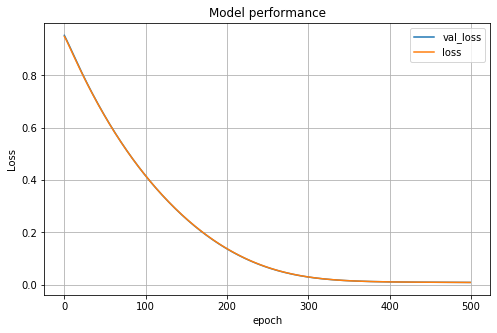

In [13]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

MSE for predicted test set: 0.008378


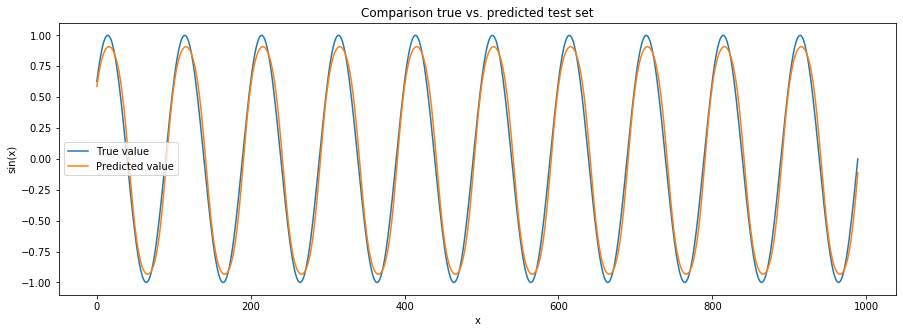

In [14]:
# Predict on test data.
pred_test = model.predict(test_X)

# Apply inverse transformation to get back true values.
test_y_actual = scaler.inverse_transform(test_Y.values.reshape(test_Y.shape[0], 1))

print("MSE for predicted test set: %2f" % mean_squared_error(test_y_actual, pred_test))

plt.figure(figsize = (15, 5))
plt.plot(test_y_actual, label="True value")
plt.plot(pred_test, label="Predicted value")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.title("Comparison true vs. predicted test set")
plt.legend()
plt.show()

## Build LSTM model on training data

The model architecture used here is slightly more complex. Its elements are:

- LSTM input layer with 50 units.
- Dropout layer to prevent overfitting (see: http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf).
- A second LSTM layer with 256 units.
- A further Dropout layer.
- A Dense layer to produce a single output.
- Use MSE as loss function.

In [15]:
# Define the model.
model = Sequential()
model.add(LSTM(input_shape = (window_size, 1), units = window_size, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))

model.compile(loss = "mean_squared_error", optimizer = "adam")

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 325,025
Trainable params: 325,025
Non-trainable params: 0
________________________________________________

## Results

Predictions and model evaluation

In [16]:
# Fit the model.
history = model.fit(train_X, train_Y, batch_size = 512, epochs = 3, validation_data = (test_X, test_Y))

Train on 3960 samples, validate on 990 samples
Epoch 1/3
3960/3960 [==============================] - 19s 5ms/step - loss: 0.2362 - val_loss: 0.0439
Epoch 2/3
3960/3960 [==============================] - 18s 5ms/step - loss: 0.0296 - val_loss: 0.0082
Epoch 3/3
3960/3960 [==============================] - 17s 4ms/step - loss: 0.0172 - val_loss: 0.0059


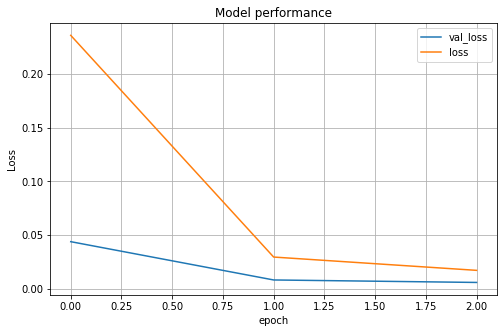

In [17]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
rmse_train, train_predict = predict_and_score(model, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 0.08 RMSE
Test data score: 0.08 RMSE


MSE for predicted test set: 0.005883


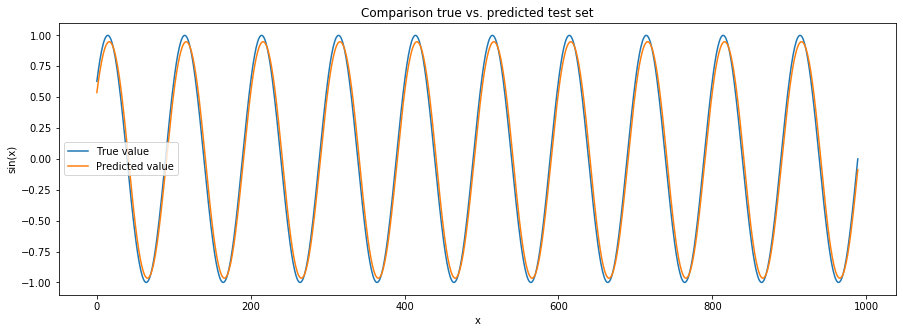

In [19]:
# Predict on test data.
pred_test = model.predict(test_X)

# Apply inverse transformation to get back true values.
test_y_actual = scaler.inverse_transform(test_Y.values.reshape(test_Y.shape[0], 1))

print("MSE for predicted test set: %2f" % mean_squared_error(test_y_actual, pred_test))

plt.figure(figsize = (15, 5))
plt.plot(test_y_actual, label="True value")
plt.plot(pred_test, label="Predicted value")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.title("Comparison true vs. predicted test set")
plt.legend()
plt.show()

# Sinus avec Bruit

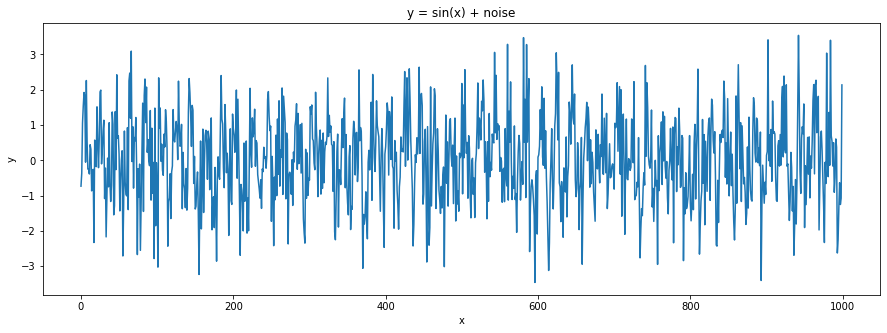

In [20]:
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot

SAMPLES = 1000
PERIOD = 50

# seed random number generator
seed(1)
# create white noise series
noise = np.random.normal(loc=0.0, scale=1.0, size=1000)
x = np.linspace(-PERIOD * np.pi, PERIOD * np.pi, SAMPLES)
noise = pd.DataFrame(noise)
sinus = pd.DataFrame(np.sin(x))

series = pd.DataFrame(sinus.values + noise.values)

plt.figure(figsize = (15, 5))
plt.plot(series.values)
plt.xlabel("x")
plt.ylabel("y")
plt.title("y = sin(x) + noise")
plt.show()

In [21]:
# Normalize data on the (-1, 1) interval.
scaler = MinMaxScaler(feature_range = (-1, 1))
scaled = scaler.fit_transform(series.values)

# Convert to data frame.
series = pd.DataFrame(scaled)

# Helper function to create a windowed data set.

def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], 
                            axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

series_backup = series.copy()
t = create_window(series_backup, 1)
t.head()

,0,0
0,-0.220861,-0.115039
1,-0.115039,0.289773
2,0.289773,0.430269
3,0.430269,0.537585
4,0.537585,0.501616


In [22]:
window_size = 50
series = create_window(series, window_size)
print("Shape of input data:")
print(series.shape)

Shape of input data:
(950, 51)


In [23]:
# Using 80% of data for training, 20% for validation.

TRAIN_SIZE = 0.80

nrow = round(TRAIN_SIZE * series.shape[0])

train = series.iloc[:nrow, :]
test = series.iloc[nrow:, :]

# Shuffle training data.
train = shuffle(train)

train_X = train.iloc[:, :-1]
test_X = test.iloc[:, :-1]

train_Y = train.iloc[:, -1]
test_Y = test.iloc[:, -1]

print("Training set shape for X (inputs):")
print(train_X.shape)
print("Training set shape for Y (output):")
print(train_Y.shape)

Training set shape for X (inputs):
(760, 50)
Training set shape for Y (output):
(760,)


In [24]:
train_X = np.reshape(train_X.values, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X.values, (test_X.shape[0], test_X.shape[1], 1))

print(train_X.shape)
print(test_X.shape)

(760, 50, 1)
(190, 50, 1)


In [25]:
window_size = 50

# Define the model.
model = Sequential()
model.add(GRU(4, input_shape = (window_size, 1)))
model.add(Dense(1))

model.compile(loss = "mean_squared_error", optimizer = "adam")

model.summary()

# Fit the model.
history = model.fit(train_X, train_Y, epochs = 500, batch_size = train_X.shape[0], validation_data = (test_X, test_Y))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 4)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________
Train on 760 samples, validate on 190 samples
Epoch 1/500
760/760 [==============================] - 1s 1ms/step - loss: 0.1122 - val_loss: 0.1280
Epoch 2/500
760/760 [==============================] - 0s 117us/step - loss: 0.1121 - val_loss: 0.1279
Epoch 3/500
760/760 [==============================] - 0s 107us/step - loss: 0.1120 - val_loss: 0.1279
Epoch 4/500
760/760 [==============================] - 0s 107us/step - loss: 0.1119 - val_loss: 0.1278
Epoch 5/500
760/760 [==============================] - 0s 109us/

Epoch 74/500
760/760 [==============================] - 0s 112us/step - loss: 0.1079 - val_loss: 0.1247
Epoch 75/500
760/760 [==============================] - 0s 113us/step - loss: 0.1079 - val_loss: 0.1247
Epoch 76/500
760/760 [==============================] - 0s 122us/step - loss: 0.1078 - val_loss: 0.1247
Epoch 77/500
760/760 [==============================] - 0s 114us/step - loss: 0.1078 - val_loss: 0.1247
Epoch 78/500
760/760 [==============================] - 0s 112us/step - loss: 0.1078 - val_loss: 0.1246
Epoch 79/500
760/760 [==============================] - 0s 114us/step - loss: 0.1078 - val_loss: 0.1246
Epoch 80/500
760/760 [==============================] - 0s 112us/step - loss: 0.1078 - val_loss: 0.1246
Epoch 81/500
760/760 [==============================] - 0s 109us/step - loss: 0.1077 - val_loss: 0.1246
Epoch 82/500
760/760 [==============================] - 0s 116us/step - loss: 0.1077 - val_loss: 0.1246
Epoch 83/500
760/760 [==============================] - 0s 109us

Epoch 153/500
760/760 [==============================] - 0s 122us/step - loss: 0.1068 - val_loss: 0.1242
Epoch 154/500
760/760 [==============================] - 0s 122us/step - loss: 0.1068 - val_loss: 0.1242
Epoch 155/500
760/760 [==============================] - 0s 112us/step - loss: 0.1068 - val_loss: 0.1242
Epoch 156/500
760/760 [==============================] - 0s 114us/step - loss: 0.1068 - val_loss: 0.1242
Epoch 157/500
760/760 [==============================] - 0s 113us/step - loss: 0.1068 - val_loss: 0.1242
Epoch 158/500
760/760 [==============================] - 0s 113us/step - loss: 0.1068 - val_loss: 0.1242
Epoch 159/500
760/760 [==============================] - 0s 109us/step - loss: 0.1068 - val_loss: 0.1242
Epoch 160/500
760/760 [==============================] - 0s 109us/step - loss: 0.1068 - val_loss: 0.1242
Epoch 161/500
760/760 [==============================] - 0s 112us/step - loss: 0.1067 - val_loss: 0.1242
Epoch 162/500
760/760 [==============================] 

760/760 [==============================] - 0s 109us/step - loss: 0.1060 - val_loss: 0.1239
Epoch 232/500
760/760 [==============================] - 0s 116us/step - loss: 0.1060 - val_loss: 0.1239
Epoch 233/500
760/760 [==============================] - 0s 109us/step - loss: 0.1060 - val_loss: 0.1239
Epoch 234/500
760/760 [==============================] - 0s 112us/step - loss: 0.1059 - val_loss: 0.1239
Epoch 235/500
760/760 [==============================] - 0s 109us/step - loss: 0.1059 - val_loss: 0.1239
Epoch 236/500
760/760 [==============================] - 0s 112us/step - loss: 0.1059 - val_loss: 0.1239
Epoch 237/500
760/760 [==============================] - 0s 114us/step - loss: 0.1059 - val_loss: 0.1239
Epoch 238/500
760/760 [==============================] - 0s 126us/step - loss: 0.1059 - val_loss: 0.1239
Epoch 239/500
760/760 [==============================] - 0s 111us/step - loss: 0.1059 - val_loss: 0.1239
Epoch 240/500
760/760 [==============================] - 0s 108us/ste

Epoch 310/500
760/760 [==============================] - 0s 108us/step - loss: 0.1032 - val_loss: 0.1227
Epoch 311/500
760/760 [==============================] - 0s 103us/step - loss: 0.1031 - val_loss: 0.1227
Epoch 312/500
760/760 [==============================] - 0s 109us/step - loss: 0.1030 - val_loss: 0.1226
Epoch 313/500
760/760 [==============================] - 0s 105us/step - loss: 0.1029 - val_loss: 0.1226
Epoch 314/500
760/760 [==============================] - 0s 104us/step - loss: 0.1029 - val_loss: 0.1225
Epoch 315/500
760/760 [==============================] - 0s 104us/step - loss: 0.1028 - val_loss: 0.1225
Epoch 316/500
760/760 [==============================] - 0s 112us/step - loss: 0.1027 - val_loss: 0.1224
Epoch 317/500
760/760 [==============================] - 0s 107us/step - loss: 0.1026 - val_loss: 0.1224
Epoch 318/500
760/760 [==============================] - 0s 113us/step - loss: 0.1025 - val_loss: 0.1223
Epoch 319/500
760/760 [==============================] 

760/760 [==============================] - 0s 103us/step - loss: 0.0955 - val_loss: 0.1187
Epoch 389/500
760/760 [==============================] - 0s 107us/step - loss: 0.0954 - val_loss: 0.1187
Epoch 390/500
760/760 [==============================] - 0s 104us/step - loss: 0.0953 - val_loss: 0.1187
Epoch 391/500
760/760 [==============================] - 0s 101us/step - loss: 0.0953 - val_loss: 0.1186
Epoch 392/500
760/760 [==============================] - 0s 109us/step - loss: 0.0952 - val_loss: 0.1186
Epoch 393/500
760/760 [==============================] - 0s 103us/step - loss: 0.0952 - val_loss: 0.1186
Epoch 394/500
760/760 [==============================] - 0s 105us/step - loss: 0.0951 - val_loss: 0.1186
Epoch 395/500
760/760 [==============================] - 0s 104us/step - loss: 0.0951 - val_loss: 0.1186
Epoch 396/500
760/760 [==============================] - 0s 108us/step - loss: 0.0951 - val_loss: 0.1185
Epoch 397/500
760/760 [==============================] - 0s 111us/ste

Epoch 467/500
760/760 [==============================] - 0s 121us/step - loss: 0.0921 - val_loss: 0.1163
Epoch 468/500
760/760 [==============================] - 0s 132us/step - loss: 0.0920 - val_loss: 0.1163
Epoch 469/500
760/760 [==============================] - 0s 126us/step - loss: 0.0920 - val_loss: 0.1162
Epoch 470/500
760/760 [==============================] - 0s 124us/step - loss: 0.0919 - val_loss: 0.1162
Epoch 471/500
760/760 [==============================] - 0s 124us/step - loss: 0.0919 - val_loss: 0.1161
Epoch 472/500
760/760 [==============================] - 0s 120us/step - loss: 0.0919 - val_loss: 0.1161
Epoch 473/500
760/760 [==============================] - 0s 129us/step - loss: 0.0918 - val_loss: 0.1160
Epoch 474/500
760/760 [==============================] - 0s 118us/step - loss: 0.0918 - val_loss: 0.1160
Epoch 475/500
760/760 [==============================] - 0s 128us/step - loss: 0.0917 - val_loss: 0.1159
Epoch 476/500
760/760 [==============================] 

In [26]:
rmse_train, train_predict = predict_and_score(model, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 1.05 RMSE
Test data score: 1.18 RMSE


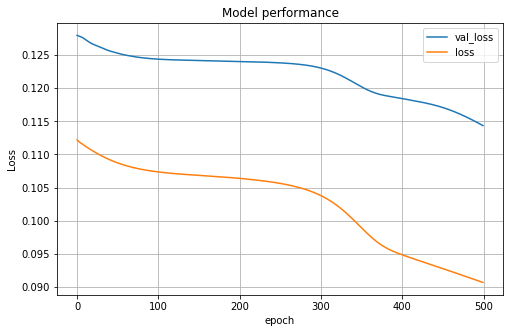

In [27]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

MSE for predicted test set: 1.509066


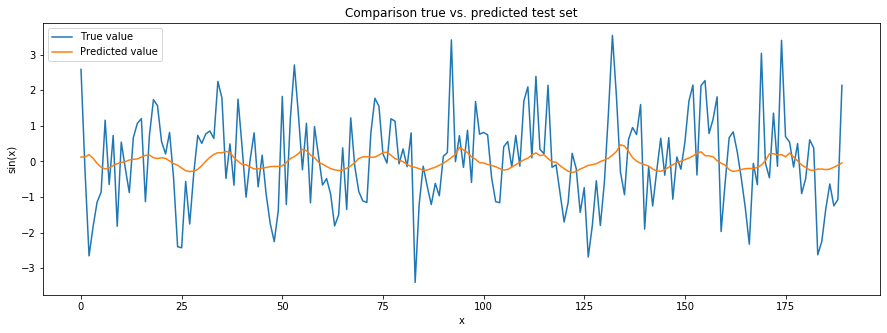

In [28]:
# Predict on test data.
pred_test = model.predict(test_X)

# Apply inverse transformation to get back true values.
test_y_actual = scaler.inverse_transform(test_Y.values.reshape(test_Y.shape[0], 1))

print("MSE for predicted test set: %2f" % mean_squared_error(test_y_actual, pred_test))

plt.figure(figsize = (15, 5))
plt.plot(test_y_actual, label="True value")
plt.plot(pred_test, label="Predicted value")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.title("Comparison true vs. predicted test set")
plt.legend()
plt.show()

# Example 2: Airline Passenger Data¶

In this example we wish to make forcasts on a time series of international airline passengers.

Loading and plotting the data

In [29]:
data = pd.read_csv('airline_passengers.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

     Month  Thousands of Passengers
0  1949-01                      112
1  1949-02                      118
2  1949-03                      132
3  1949-04                      129
4  1949-05                      121

 Data Types:
Month                      object
Thousands of Passengers     int64
dtype: object


In [30]:
con=data['Month']
data['Month']=pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
#check datatype of index
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

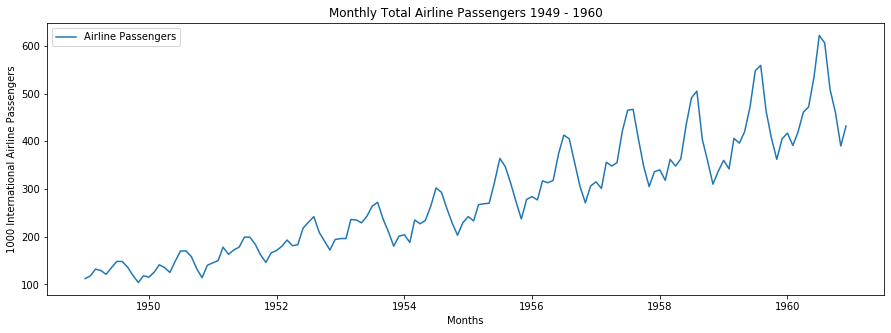

In [31]:
# Create a time series plot.
plt.figure(figsize = (15, 5))
plt.plot(data, label = "Airline Passengers")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Monthly Total Airline Passengers 1949 - 1960")
plt.legend()
plt.show()

We can observe a strong upwards trend in terms of numbers of passgengers with some seasonality component. The seasonality may be understood to conincide with holiday periods, but we'd need to have a closer look at the actual time periods to confirm this.

We could also consider de-trending the time series and applying further "cleaning" techniques, which would be a prerequisite e.g. in an ARIMA setting.

However, for simplicity reasons we will just proceed with the data as is.

The only transformations we'll be doing are:

- Scale data to the  (0,1)  interval for increased numerical stability.
- Re-shape the data so we have one column as response (called  Y  in the code) and another one as predictor variable (called X in the code).

## Data Preparation

In [32]:
# Get the raw data values from the pandas data frame.
data_raw = data.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
dataset[0:5]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]], dtype=float32)

Split into test / training data

As usual, the data gets split into training and test data so we can later assess how well the final model performs.

In [33]:
# Using 80% of data for training, 20% for validation.
TRAIN_SIZE = 0.80

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (115, 29)


Get data into shape to use in Keras

In [34]:
def create_dataset(dataset, window_size):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [35]:
# Create test and training sets for one-step-ahead regression.
window_size = 3
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(111, 3)
New training data shape:
(111, 3, 1)


## Build simple LSTM model on airplane data

The LSTM architecture here consists of:

- One input layer.
- One LSTM layer of 4 blocks.
- One Dense layer to produce a single output.
- Use MSE as loss function.

Many different architectures could be considered. But this is just a quick test, so we'll keep things nice and simple.

In [36]:
window_size = 3

# Define the model.
model1 = Sequential()
model1.add(LSTM(4, input_shape = (window_size, 1)))
model1.add(Dense(1))

model1.compile(loss = "mean_squared_error", optimizer = "adam")

model1.summary()

# Fit the first model.
history1 = model1.fit(train_X, train_Y, epochs = 60, batch_size = 1, validation_data = (test_X, test_Y))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Train on 111 samples, validate on 25 samples
Epoch 1/60
111/111 [==============================] - 1s 13ms/step - loss: 0.0231 - val_loss: 0.0727
Epoch 2/60
111/111 [==============================] - 1s 6ms/step - loss: 0.0111 - val_loss: 0.0535
Epoch 3/60
111/111 [==============================] - 1s 6ms/step - loss: 0.0087 - val_loss: 0.0447
Epoch 4/60
111/111 [==============================] - 1s 6ms/step - loss: 0.0071 - val_loss: 0.0367
Epoch 5/60
111/111 [==============================] - 1s 6ms/step - loss

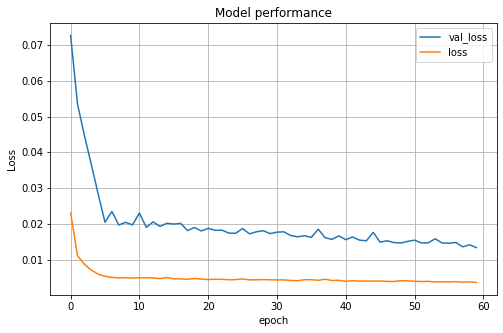

In [37]:
pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 30.82 RMSE
Test data score: 59.83 RMSE


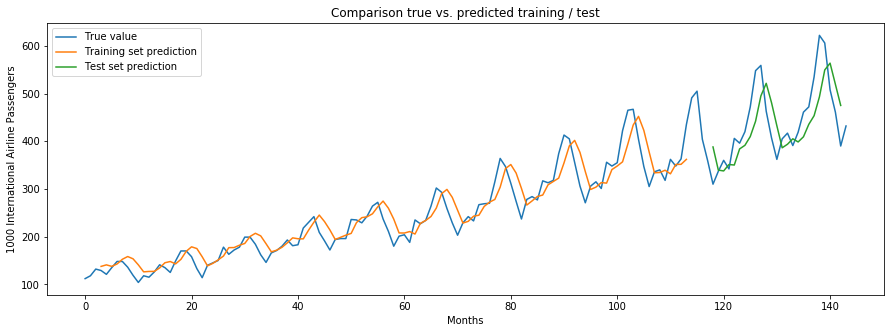

In [39]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

# Build simple GRU model on airplane data

The architecture here consists of:

One input layer.
One GRU layer of 4 blocks.
One Dense layer to produce a single output.
Use MSE as loss function.

In [40]:
window_size = 3

# Define the model.
model2 = Sequential()
model2.add(GRU(4, input_shape = (window_size, 1)))
model2.add(Dense(1))

model2.compile(loss = "mean_squared_error", optimizer = "adam")

model2.summary()

# Fit the first model.
history2 = model2.fit(train_X, train_Y, epochs = 100, batch_size = 1, validation_data = (test_X, test_Y))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 4)                 72        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________
Train on 111 samples, validate on 25 samples
Epoch 1/100
111/111 [==============================] - 2s 14ms/step - loss: 0.0268 - val_loss: 0.0829
Epoch 2/100
111/111 [==============================] - 1s 7ms/step - loss: 0.0115 - val_loss: 0.0632
Epoch 3/100
111/111 [==============================] - 1s 7ms/step - loss: 0.0092 - val_loss: 0.0464
Epoch 4/100
111/111 [==============================] - 1s 7ms/step - loss: 0.0072 - val_loss: 0.0351
Epoch 5/100
111/111 [==============================] - 1s 7ms/step - l

Epoch 75/100
111/111 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0102
Epoch 76/100
111/111 [==============================] - 1s 7ms/step - loss: 0.0027 - val_loss: 0.0093
Epoch 77/100
111/111 [==============================] - 1s 7ms/step - loss: 0.0025 - val_loss: 0.0100
Epoch 78/100
111/111 [==============================] - 1s 7ms/step - loss: 0.0025 - val_loss: 0.0083
Epoch 79/100
111/111 [==============================] - 1s 7ms/step - loss: 0.0027 - val_loss: 0.0086
Epoch 80/100
111/111 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0091
Epoch 81/100
111/111 [==============================] - 1s 7ms/step - loss: 0.0027 - val_loss: 0.0086
Epoch 82/100
111/111 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0110
Epoch 83/100
111/111 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0093
Epoch 84/100
111/111 [==============================] - 1s 7ms/step - loss: 0.0025

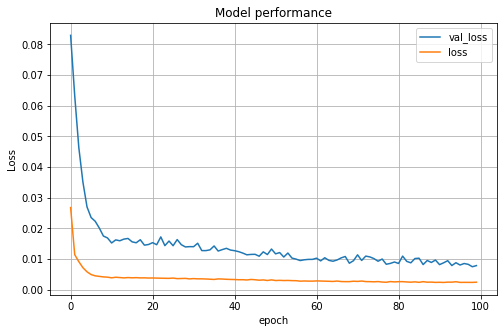

In [41]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [42]:
rmse_train, train_predict = predict_and_score(model2, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model2, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 25.14 RMSE
Test data score: 46.03 RMSE


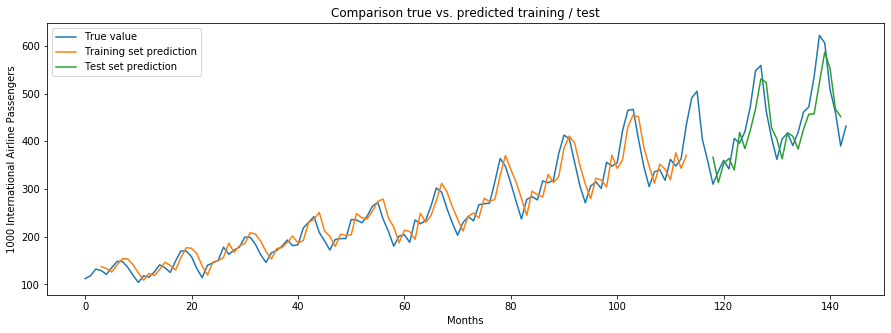

In [43]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

# Build simple RNN model on airplane data

The architecture here consists of:

One input layer.
One RNN layer of 4 blocks.
One Dense layer to produce a single output.
Use MSE as loss function.

In [44]:
window_size = 3

# Define the model.
model3 = Sequential()
model3.add(SimpleRNN(4, input_shape = (window_size, 1)))
model3.add(Dense(1))

model3.compile(loss = "mean_squared_error", optimizer = "adam")

model3.summary()

# Fit the first model.
history3 = model3.fit(train_X, train_Y, epochs = 60, batch_size = 1, validation_data = (test_X, test_Y))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 4)                 24        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
Train on 111 samples, validate on 25 samples
Epoch 1/60
111/111 [==============================] - 1s 9ms/step - loss: 0.0090 - val_loss: 0.0504
Epoch 2/60
111/111 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0492
Epoch 3/60
111/111 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0509
Epoch 4/60
111/111 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0380
Epoch 5/60
111/111 [==============================] - 0s 4ms/step - loss: 0

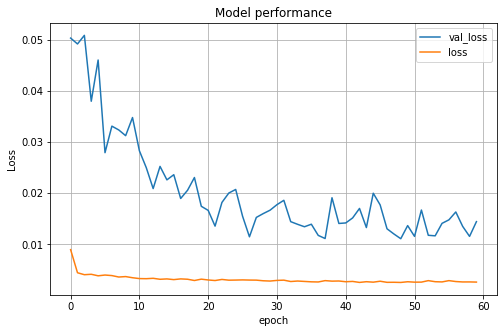

In [45]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
rmse_train, train_predict = predict_and_score(model3, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model3, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 25.29 RMSE
Test data score: 62.26 RMSE


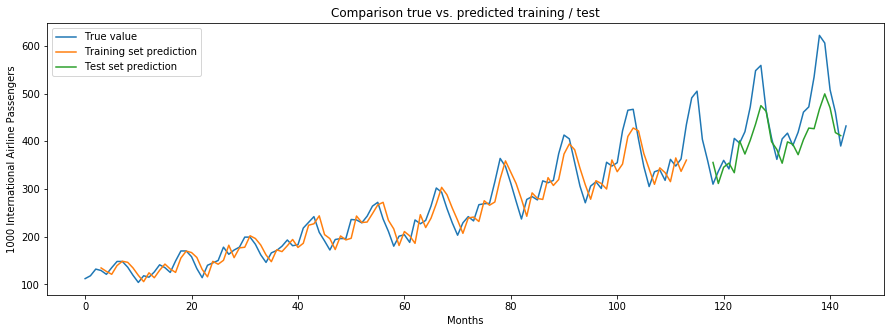

In [47]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

## Next steps and things to explore

- Work with de-trended, stationary time series. Does it improve performance?
- Different window size (multiple regression). See Example 2.
- LSTM architecture, i.e. more layers, neurons etc.
- Impact of various hyperparameters in LSTM network on prediction accuracy.
- Model selection steps to find the "best" model.

# Build XGBOOST on airplane data

In [48]:
# Create test and training sets for one-step-ahead regression.
window_size = 3
X_train, y_train = create_dataset(train, window_size)
X_test, y_test = create_dataset(test, window_size)
print("Original training data shape:")
print(X_train.shape)
print(X_test.shape)

Original training data shape:
(111, 3)
(25, 3)


In [49]:
reg = xgb.XGBRegressor()

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [50]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X).reshape(1, -1))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = np.sqrt(mean_squared_error(orig_data[0], pred[0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(reg, X_train, y_train)
rmse_test, test_predict = predict_and_score(reg, X_test, y_test)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 7.28 RMSE
Test data score: 92.78 RMSE


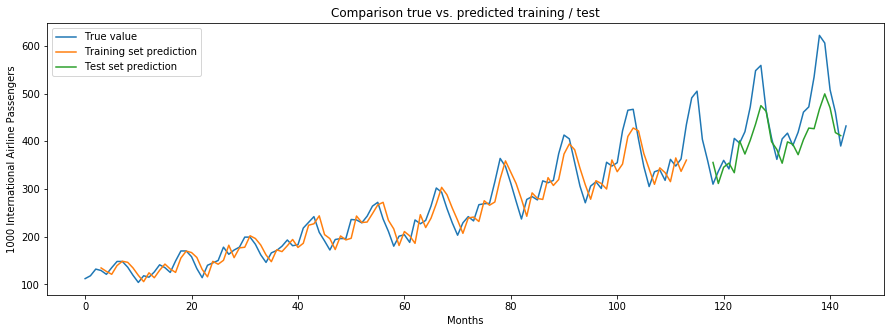

In [51]:
# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

# Build a Conv-1D on airplane data

In [52]:
# we have only 1 feature here
n_features = 1

# choose a number of time steps
n_steps = 3

# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print(X_train.shape)
print(X_test.shape)

(111, 3, 1)
(25, 3, 1)


In [53]:
# define model
cnn = Sequential()
cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
# cnn.add(LeakyReLU(alpha=0.1))
cnn.add(Dense(1))

cnn.compile(optimizer='adam', loss='mse')

cnn.summary()

# fit model
history_cnn = cnn.fit(X_train, y_train, epochs=80, validation_data=(X_test, y_test))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2, 64)             192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
Train on 111 samples, validate on 25 samples
Epoch 1/80
111/111 [==============================] - 0s 2ms/step - loss: 0.1029 - val_loss: 0.4355
Epoch 2/80
111/111 [==============================] - 0s 144us/step - loss: 0.0828 - val_loss: 0.3647
Epoch 3

111/111 [==============================] - 0s 162us/step - loss: 0.0050 - val_loss: 0.0219
Epoch 72/80
111/111 [==============================] - 0s 153us/step - loss: 0.0050 - val_loss: 0.0217
Epoch 73/80
111/111 [==============================] - 0s 144us/step - loss: 0.0050 - val_loss: 0.0214
Epoch 74/80
111/111 [==============================] - 0s 135us/step - loss: 0.0050 - val_loss: 0.0212
Epoch 75/80
111/111 [==============================] - 0s 153us/step - loss: 0.0050 - val_loss: 0.0211
Epoch 76/80
111/111 [==============================] - 0s 135us/step - loss: 0.0050 - val_loss: 0.0211
Epoch 77/80
111/111 [==============================] - 0s 144us/step - loss: 0.0050 - val_loss: 0.0212
Epoch 78/80
111/111 [==============================] - 0s 135us/step - loss: 0.0050 - val_loss: 0.0213
Epoch 79/80
111/111 [==============================] - 0s 108us/step - loss: 0.0050 - val_loss: 0.0216
Epoch 80/80
111/111 [==============================] - 0s 135us/step - loss: 0.0050 -

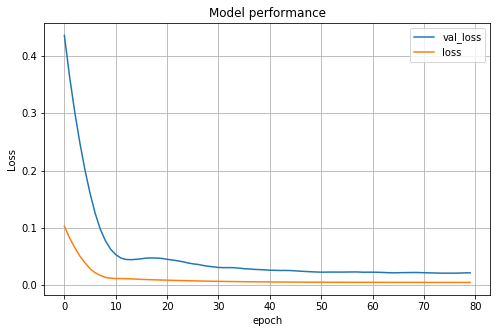

In [54]:
pd.DataFrame(history_cnn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [55]:
rmse_train, train_predict = predict_and_score(cnn, train_X, train_Y)
rmse_test, test_predict = predict_and_score(cnn, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 36.45 RMSE
Test data score: 76.26 RMSE


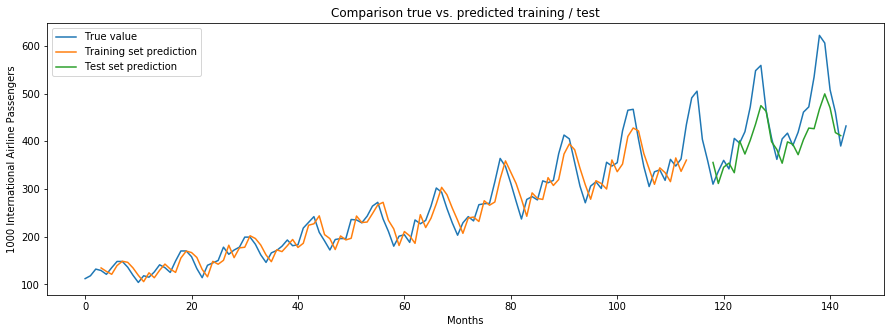

In [56]:
# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

# Scoring RMSE Results

Avec window_size de 1:

|   | LSTM | GRU | RNN | XGBOOST | CNN |
|---|---|---|---|---|---|
| train  | 26.15 | 26.69 | 26.17 | 14.46 | 26.72 |
| test  | 51.86  | 51 | 60.06 | 87.79 | 55.18 |

Avec window_size de 3:

|   | LSTM | GRU | RNN | XGBOOST | CNN |
|---|---|---|---|---|---|
| train  | 31.32 | 27.44 | 24.65 | 7.28 | 33.45 |
| test  | 67.90 | 53.56 | 49.52 | 92.78 | 68.67 |

Avec window_size de 10:

|   | LSTM | GRU | RNN | XGBOOST | CNN |
|---|---|---|---|---|---|
| train  | 30.72 | 25.39 | 28.77 | 3.86 | 39.05 |
| test  | 65.13 | 57.51 | 80.11 | 94.04 | 93.38 |

Les meilleures courbes sont obtenues avec un window_size de 3